In [1]:
#!pip install -r requirements.txt

import os
os.environ['PATH'] += os.pathsep + '/home/jovyan/.local/bin'

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import awkward as ak
from statistics import median
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import random
import json
import sys

# Load data

In [3]:
import s3fs

s3 = s3fs.core.S3FileSystem(anon=True, client_kwargs={'endpoint_url': 'https://s3.cern.ch'})

In [4]:
flist = s3.glob('s3://jec-data/open/katib/test/*.root')

In [5]:
flist

['jec-data/open/katib/test/JetNtuple_RunIISummer16_13TeV_MC_103.root',
 'jec-data/open/katib/test/JetNtuple_RunIISummer16_13TeV_MC_96.root']

In [6]:
from utils.config import DataConfig
from utils.fileio import read_files
from utils.preprocess import build_new_variables, finalize_inputs

def get_data(data_config_file):
    data_config = DataConfig.load(data_config_file)
    table = read_files(flist, data_config.load_branches, s3)
    # define new variables
    build_new_variables(table, data_config.var_funcs)
    # perform input variable standardization, clipping, padding and stacking
    finalize_inputs(table, data_config)
    
    input_data = {key: table[f'_{key}'] for key in data_config.inputs.keys()}
    
    observers = ak.to_dataframe({k: table[k] for k in data_config.observers})
    
    return input_data, observers

In [7]:
pfn_input_data, observers = get_data('https://raw.githubusercontent.com/deinal/weaver/dev/jet-energy-corrections/data/jec_pfn_open.yaml')
for key in pfn_input_data:
    print(key, pfn_input_data[key].shape)

/home/jovyan/.local/lib/python3.8/site-packages/awkward/_backends.py:58: RuntimeWarning: divide by zero encountered in log
  return getattr(ufunc, method)(*args, **kwargs)


pf_features (286645, 6, 100)
pf_mask (286645, 1, 100)
jet_features (286645, 8)


In [8]:
particlenet_input_data, _ = get_data('https://raw.githubusercontent.com/deinal/weaver/dev/jet-energy-corrections/data/jec_particle_net_open.yaml')
for key in particlenet_input_data:
    print(key, particlenet_input_data[key].shape)

/home/jovyan/.local/lib/python3.8/site-packages/awkward/_backends.py:58: RuntimeWarning: divide by zero encountered in log
  return getattr(ufunc, method)(*args, **kwargs)


pf_points (286645, 2, 100)
pf_features (286645, 6, 100)
pf_mask (286645, 1, 100)
jet_features (286645, 8)


In [9]:
observers.head()

,jetPt,genJetPt,genJetEta,partonFlav,hadronFlav
entry,,,,,
0,57.387169,59.624565,-2.215691,21.0,0.0
1,34.731983,48.733902,-1.511485,4.0,4.0
2,334.307159,315.566498,-1.439479,21.0,0.0
3,215.078369,290.740326,-1.383814,3.0,0.0
4,53.059177,54.193817,-0.552095,21.0,0.0


In [10]:
data_len = observers.shape[0]

In [11]:
df = observers.copy()
df.columns = ['pt', 'pt_gen', 'eta_gen', 'parton_flavor', 'hadron_flavor']
df['flavour'] = df.hadron_flavor.where(df.hadron_flavor != 0, other=np.abs(df.parton_flavor))
df = df.drop(columns=['parton_flavor', 'hadron_flavor'])
df.head()

,pt,pt_gen,eta_gen,flavour
entry,,,,
0,57.387169,59.624565,-2.215691,21.0
1,34.731983,48.733902,-1.511485,4.0
2,334.307159,315.566498,-1.439479,21.0
3,215.078369,290.740326,-1.383814,3.0
4,53.059177,54.193817,-0.552095,21.0


# Triton inference

### Set up client

In [12]:
import tritonclient.http as httpclient

In [13]:
pfn_triton_client_cpu = httpclient.InferenceServerClient(url='pfn-regressor-open-de181d.dholmber.svc.cluster.local', verbose=False)
particlenet_triton_client_cpu = httpclient.InferenceServerClient(url='particle-net-regressor-open-793295.dholmber.svc.cluster.local', verbose=False)

In [14]:
pfn_triton_client_gpu = httpclient.InferenceServerClient(url='pfn-regressor-open-gpu.dholmber.svc.cluster.local', verbose=False)
particlenet_triton_client_gpu = httpclient.InferenceServerClient(url='particle-net-regressor-open-gpu.dholmber.svc.cluster.local', verbose=False)

In [15]:
def infer(triton_client, inputs):
    triton_inputs = []
    for i, key in enumerate(inputs.keys()):
        triton_inputs.append(httpclient.InferInput(name=key, shape=inputs[key].shape, datatype="FP32"))
        triton_inputs[i].set_data_from_numpy(inputs[key])

    triton_outputs = [httpclient.InferRequestedOutput(name='output')]

    results = triton_client.infer(
        model_name='optimal',
        inputs=triton_inputs,
        outputs=triton_outputs
    )
    return results

### Initialize inference experiment parameters

In [78]:
num_repeats = 100
batch_sizes = [int(i) for i in np.logspace(start=1, stop=10, num=10, base=2)]

### Gather statistics

In [19]:
def gather_statistics(triton_client, input_data, num_repeats, batch_sizes):
    batch_stats = {batch_size: {'inference_time': [], 'inference_count': 0, 'total_inference_time': 0} for batch_size in batch_sizes}
    
    statistics = triton_client.get_inference_statistics(model_name='optimal')
    initial_batch_stats = statistics['model_stats'][0]['batch_stats']

    for initial_stat in initial_batch_stats:
        batch_size = initial_stat['batch_size']
        if batch_size in batch_sizes:
            initial_inference = initial_stat['compute_infer']
            batch_stats[batch_size]['total_inference_time'] = initial_inference['ns']
    
    for batch_size in tqdm(batch_sizes):
        while batch_stats[batch_size]['inference_count'] < num_repeats:
            indices = random.sample(range(data_len), batch_size)
            inputs = {}
            for key in input_data:
                inputs[key] = input_data[key][indices]

            results = infer(triton_client, inputs)

            statistics = triton_client.get_inference_statistics(model_name='optimal')
            all_current_batch_stats = statistics['model_stats'][0]['batch_stats']
            for stat in all_current_batch_stats:
                if stat['batch_size'] == batch_size:
                    current_batch = stat
                    break

            last_inference_time = current_batch['compute_infer']['ns'] - batch_stats[batch_size]['total_inference_time']

            batch_stats[batch_size]['inference_time'].append(last_inference_time / batch_size)
            batch_stats[batch_size]['total_inference_time'] = current_batch['compute_infer']['ns']
            batch_stats[batch_size]['inference_count'] += 1
    
    return batch_stats

In [18]:
gather_statistics(pfn_triton_client_cpu, pfn_input_data, 10, [16]) #warmup
pfn_stats_cpu = gather_statistics(pfn_triton_client_cpu, pfn_input_data, num_repeats, batch_sizes)

100%|██████████| 8/8 [02:00<00:00, 15.00s/it]


In [20]:
gather_statistics(particlenet_triton_client_cpu, particlenet_input_data, 10, [16])
particle_net_stats_cpu = gather_statistics(particlenet_triton_client_cpu, particlenet_input_data, num_repeats, batch_sizes)

100%|██████████| 8/8 [04:52<00:00, 36.58s/it]


In [21]:
gather_statistics(pfn_triton_client_gpu, pfn_input_data, 10, [16])
pfn_stats_gpu = gather_statistics(pfn_triton_client_gpu, pfn_input_data, num_repeats, batch_sizes)

100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


In [22]:
gather_statistics(particlenet_triton_client_gpu, particlenet_input_data, 10, [16])
particle_net_stats_gpu = gather_statistics(particlenet_triton_client_gpu, particlenet_input_data, num_repeats, batch_sizes)

100%|██████████| 8/8 [00:41<00:00,  5.24s/it]


### Calculate metrics

In [23]:
def calculate_metrics(batch_stats, batch_sizes):
    y = []
    yerr = []
    for batch_size in batch_sizes:
        batch_inference_time = [t / 10e3 for t in batch_stats[batch_size]['inference_time']]
        summed_time = sum(batch_inference_time)
        count = batch_stats[batch_size]['inference_count']
        if not count:
            continue

        # mean_time = summed_time / count
        median_time = median(batch_inference_time)
        y.append(median_time)

        sem = np.std(batch_inference_time, ddof=1) / np.sqrt(np.size(batch_inference_time))
        yerr.append(sem)
    
    return np.array(y), np.array(yerr)

In [24]:
pfn_y_cpu, pfn_yerr_cpu = calculate_metrics(pfn_stats_cpu, batch_sizes)

In [25]:
pfn_y_gpu, pfn_yerr_gpu = calculate_metrics(pfn_stats_gpu, batch_sizes)

In [26]:
particlenet_y_cpu, particlenet_yerr_cpu = calculate_metrics(particle_net_stats_cpu, batch_sizes)

In [27]:
particlenet_y_gpu, particlenet_yerr_gpu = calculate_metrics(particle_net_stats_gpu, batch_sizes)

### Plot inference time

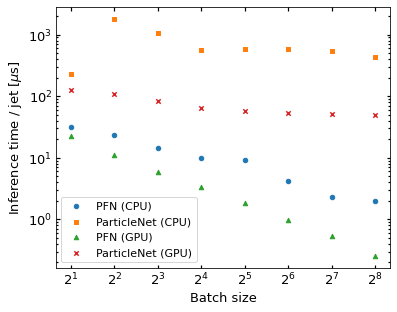

In [62]:
fig = plt.figure(figsize=(6, 4.8))
ax = fig.add_subplot()
ax.scatter(batch_sizes, pfn_y_cpu, label='PFN (CPU)', marker='o', s=20)
ax.scatter(batch_sizes, particlenet_y_cpu, label='ParticleNet (CPU)', marker='s', s=20)
ax.scatter(batch_sizes, pfn_y_gpu, label='PFN (GPU)', marker='^', s=20)
ax.scatter(batch_sizes, particlenet_y_gpu, label='ParticleNet (GPU)', marker='x', s=20)
ax.set_xlabel('Batch size', fontsize=13)
ax.set_ylabel('Inference time / jet [$\mu$s]', fontsize=13)
ax.set_xscale('log', base=2)
ax.set_xticks(batch_sizes)
ax.set_yscale('log')
plt.legend(prop={'size': 11})
ax.tick_params(
    axis='both', which='both', direction='in', width=1.2,
    bottom=True, top=True, left=True, right=True, labelsize=13
)
for ext in ['png', 'pdf', 'svg']:
    plt.savefig(f'figs/inference/comparison.{ext}')
plt.show()

In [29]:
with open('figs/inference/data.json', 'w') as f:
    data = {
        'batch_sizes': batch_sizes,
        'pfn_cpu': list(pfn_y_cpu),
        'pfn_cpu_err': list(pfn_yerr_cpu),
        'particlenet_cpu': list(particlenet_y_cpu),
        'particlenet_cpu_err': list(particlenet_yerr_cpu),
        'pfn_gpu': list(pfn_y_gpu),
        'pfn_gpu_err': list(pfn_yerr_gpu),
        'particlenet_gpu': list(particlenet_y_gpu),
        'particlenet_gpu_err': list(particlenet_yerr_gpu),
    }
    json.dump(data, f, indent='\t')

In [79]:
import time

def measure_throughput(triton_client, input_data, num_repeats, batch_sizes):
    throughput = []
    for batch_size in tqdm(batch_sizes):
        i = 0
        start = time.time()
        while i < num_repeats:
            indices = random.sample(range(data_len), batch_size)
            inputs = {}
            for key in input_data:
                inputs[key] = input_data[key][indices]
            results = infer(triton_client, inputs)
            i += 1

        end = time.time()
        time_diff = end - start

        throughput.append(batch_size * num_repeats / time_diff)
    return throughput

In [92]:
pfn_throughput_cpu = measure_throughput(pfn_triton_client_cpu, pfn_input_data, num_repeats, batch_sizes)

100%|██████████| 10/10 [01:53<00:00, 11.37s/it]


In [81]:
particlenet_throughput_cpu = measure_throughput(particlenet_triton_client_cpu, particlenet_input_data, num_repeats, batch_sizes)

100%|██████████| 10/10 [13:32<00:00, 81.26s/it] 


In [82]:
pfn_throughput_gpu = measure_throughput(pfn_triton_client_gpu, pfn_input_data, num_repeats, batch_sizes)

100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


In [88]:
particlenet_throughput_gpu = measure_throughput(particlenet_triton_client_gpu, particlenet_input_data, num_repeats, batch_sizes)

100%|██████████| 10/10 [02:01<00:00, 12.11s/it]


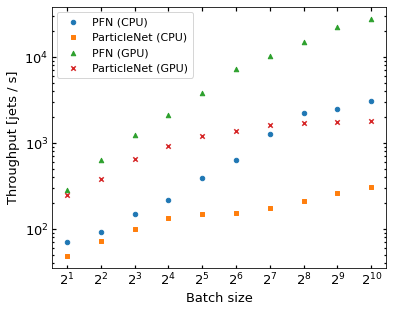

In [95]:
fig = plt.figure(figsize=(6, 4.8))
ax = fig.add_subplot()
ax.scatter(batch_sizes, pfn_throughput_cpu, label='PFN (CPU)', marker='o', s=20)
ax.scatter(batch_sizes, particlenet_throughput_cpu, label='ParticleNet (CPU)', marker='s', s=20)
ax.scatter(batch_sizes, pfn_throughput_gpu, label='PFN (GPU)', marker='^', s=20)
ax.scatter(batch_sizes, particlenet_throughput_gpu, label='ParticleNet (GPU)', marker='x', s=20)
ax.set_xlabel('Batch size', fontsize=13)
ax.set_ylabel('Throughput [jets / s]', fontsize=13)
ax.set_xscale('log', base=2)
ax.set_xticks(batch_sizes)
ax.set_yscale('log')
plt.legend(prop={'size': 11})
ax.tick_params(
    axis='both', which='both', direction='in', width=1.2,
    bottom=True, top=True, left=True, right=True, labelsize=13
)
for ext in ['png', 'pdf', 'svg']:
    plt.savefig(f'figs/throughput/comparison.{ext}')
plt.show()

In [94]:
with open('figs/throughput/data.json', 'w') as f:
    data = {
        'batch_sizes': batch_sizes,
        'pfn_cpu': list(pfn_throughput_cpu),
        'particlenet_cpu': list(particlenet_throughput_cpu),
        'pfn_gpu': list(pfn_throughput_gpu),
        'particlenet_gpu': list(particlenet_throughput_gpu),
    }
    json.dump(data, f, indent='\t')

# Physics results

In [16]:
batch_size = 100

In [17]:
def get_predictions(triton_client, input_data, batch_size):
    predictions = []

    for i in tqdm(range(0, data_len, batch_size)):
        inputs = {}
        for key in input_data:
            inputs[key] = input_data[key][i:i+batch_size]

        results = infer(triton_client, inputs)

        predictions.append(results.as_numpy(name='output'))

    return np.concatenate(predictions)

In [18]:
pfn_predictions = get_predictions(pfn_triton_client_gpu, pfn_input_data, batch_size)

100%|██████████| 2867/2867 [00:25<00:00, 114.00it/s]


In [19]:
particlenet_predictions = get_predictions(particlenet_triton_client_gpu, particlenet_input_data, batch_size)

100%|██████████| 2867/2867 [02:59<00:00, 15.94it/s]


In [20]:
outdir = 'figs'
network_names = ['PFN', 'ParticleNet']
names = ['Baseline'] + network_names
preds = {'PFN': pfn_predictions.squeeze(), 'ParticleNet': particlenet_predictions.squeeze()}

In [21]:
df['Baseline'] = df.pt / df.pt_gen
for name in network_names:
    corrected_pt = np.exp(preds[name]) * df.pt
    df[name] = corrected_pt / df.pt_gen

binning = np.geomspace(20, 3000, 20)
bin_centers = np.sqrt(binning[:-1] * binning[1:])

In [22]:
os.makedirs(outdir, exist_ok=True)

for subdir in ['distributions', 'flavours', 'response', 'resolution', 'residual']:
    for ext in ['png', 'pdf', 'svg']:
        os.makedirs(os.path.join(outdir, subdir, ext), exist_ok=True)

In [30]:
#del sys.modules[compare_flavours.__module__]
#del sys.modules[plot_resolution.__module__]
#del sys.modules[plot_median_response.__module__]
#del sys.modules[compute_resolution_improvement.__module__]
#del sys.modules[to_serializable.__module__]
#del sys.modules[plot_distrs.__module__]
#del sys.modules[plot_median_residual.__module__]

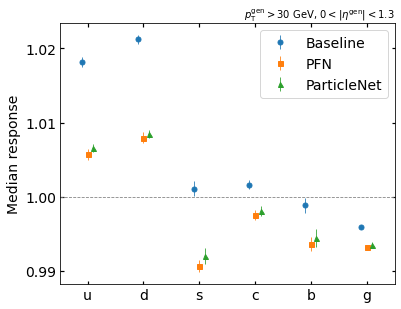

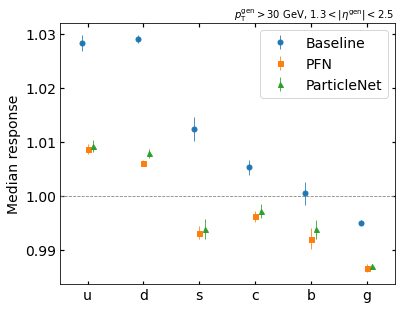

In [23]:
%%capture --no-display
from utils.plot import compare_flavours

compare_flavours(df, names, os.path.join(outdir, 'flavours'))

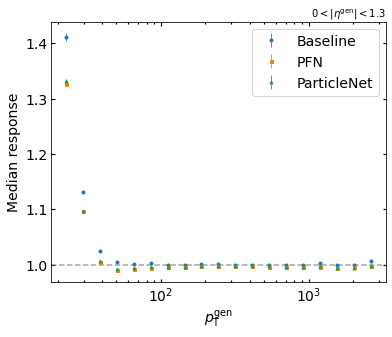

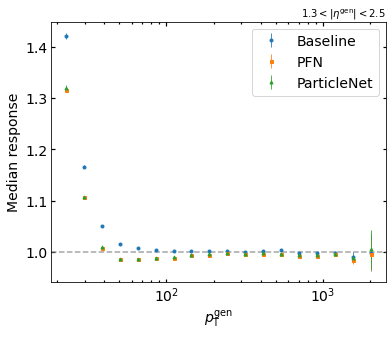

In [24]:
from utils.plot import plot_median_response

for (ieta, eta_bin), (flavour_label, flavour_ids) in itertools.product(
    enumerate([(0, 1.3), (1.3, 2.5)], start=1),
    [
        ('uds', {1, 2, 3}), ('c', {4}), ('b', {5}), ('g', {21}),
        ('all', {0, 1, 2, 3, 4, 5, 21})
    ]
):
    df_bin = df[
        (np.abs(df.eta_gen) >= eta_bin[0])
        & (np.abs(df.eta_gen) < eta_bin[1])
        & df.flavour.isin(flavour_ids)
    ]
    bins = df_bin.groupby(pd.cut(df_bin.pt_gen, binning))

    plot_median_response(
        os.path.join(outdir, 'response'),
        flavour_label, bins, bin_centers, eta_bin, ieta, names
    )

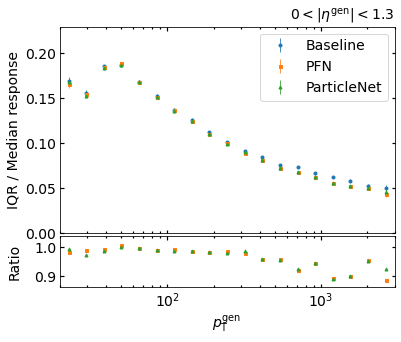

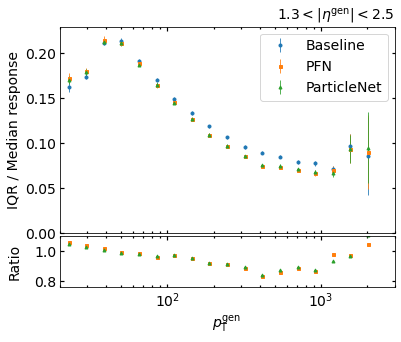

In [31]:
from utils.plot import plot_resolution, compute_resolution_improvement, to_serializable

data = {}
for (ieta, eta_bin), (flavour_label, flavour_ids) in itertools.product(
    enumerate([(0, 1.3), (1.3, 2.5)], start=1),
    [
        ('uds', {1, 2, 3}), ('c', {4}), ('b', {5}), ('g', {21}),
        ('all', {0, 1, 2, 3, 4, 5, 21})
    ]
):
    df_bin = df[
        (np.abs(df.eta_gen) >= eta_bin[0])
        & (np.abs(df.eta_gen) < eta_bin[1])
        & df.flavour.isin(flavour_ids)
    ]
    bins = df_bin.groupby(pd.cut(df_bin.pt_gen, binning))

    data[f'{flavour_label}_eta{ieta}'] = plot_resolution(
        os.path.join(outdir, 'resolution'),
        flavour_label, bins, bin_centers, eta_bin, ieta, binning, names
    )

    for (ipt, pt_bin) in enumerate(
            [(30, np.inf), (30, 100), (100, 300), (300, 1000), (1000, np.inf)], start=1
        ):
        pt_bin = df_bin[
            (df_bin.pt_gen >= pt_bin[0])
            & (df_bin.pt_gen < pt_bin[1])
        ]
        data[f'{flavour_label}_eta{ieta}']['improvement'][f'pt{ipt}'] = compute_resolution_improvement(pt_bin, names)

with open(os.path.join(outdir, 'resolution', 'data.json'), 'w') as f:
    json.dump(data, f, indent='\t', default=to_serializable)

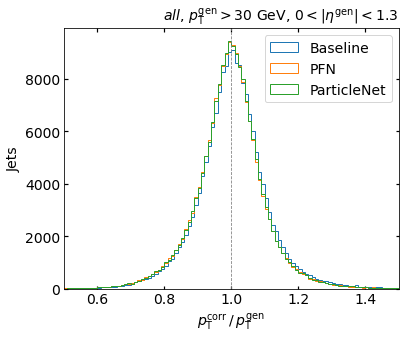

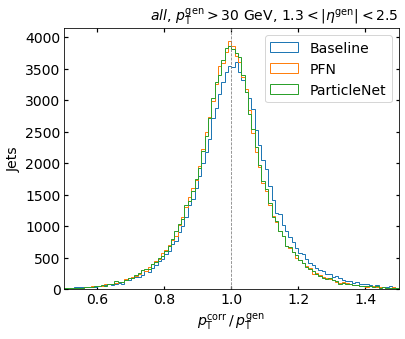

In [41]:
from utils.plot import plot_distrs

plot_distrs(df, names, os.path.join(outdir, 'distributions'))

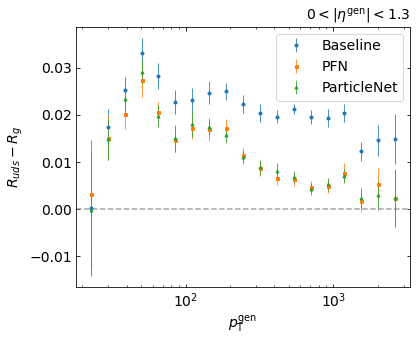

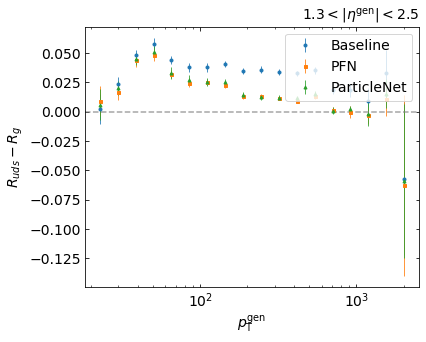

In [42]:
from utils.plot import plot_median_residual

for (ieta, eta_bin), flavours in itertools.product(
    enumerate([(0, 1.3), (1.3, 2.5)], start=1),
    itertools.combinations([('uds', {1, 2, 3}), ('c', {4}), ('b', {5}), ('g', {21})], r=2),
):
    bins = []
    for i, flavour_ids in enumerate([flavours[0][1], flavours[1][1]]):
        df_bin = df[
            (np.abs(df.eta_gen) >= eta_bin[0])
            & (np.abs(df.eta_gen) < eta_bin[1])
            & df.flavour.isin(flavour_ids)
        ]
        bins.append(df_bin.groupby(pd.cut(df_bin.pt_gen, binning)))

    plot_median_residual(
        os.path.join(outdir, 'residual'),
        bin_centers, (flavours[0][0], flavours[1][0]), bins, eta_bin, ieta, names
    )